In [1]:
from WingWatch.Intersections.detection import Detection
from WingWatch.Intersections import tri
import trimesh
import pandas as pd
import numpy as np
import WingWatch.Intersections.physicalTrackLimiter as PTL
from WingWatch.Equipment import station
from WingWatch.Equipment import antenna
from WingWatch.Tools import translation,spheres
from WingWatch.Tools import point_check as pc
import matplotlib.pyplot as plt
import scipy.spatial as ss

test_data_file = 'Fake_Calibration_Data.csv'
df = pd.read_csv(test_data_file)


Station_1 = station.Station('Station_1',41.1479, -71.5901)
Station_1_Comp_Data = pd.read_csv(test_data_file)
Station_2_pos = translation.convert_back_to_lla([0,-200,0],Station_1.lat,Station_1.long,Station_1.alt)
Station_3_pos = translation.convert_back_to_lla([100*np.sqrt(3),-100,0],Station_1.lat,Station_1.long,Station_1.alt)


freq_of_antenna_MHz = 434
antenna_number = '1'
antenna_type = 'test'
bearing_of_antenna = 0 


a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_1_Comp_Data)
Station_1.add_antenna(a1)

Station_2 = station.Station('Station_2',Station_2_pos[0], Station_2_pos[1])
Station_2_Comp_Data = pd.read_csv(test_data_file)


a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_2_Comp_Data)
Station_2.add_antenna(a1)




Station_3 = station.Station('Station_3',Station_3_pos[0], Station_3_pos[1])
Station_3_Comp_Data = pd.read_csv(test_data_file)

a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_3_Comp_Data)
Station_3.add_antenna(a1)


df_detections = pd.read_csv('straight_walk_Detections.csv')
df_walk = pd.read_csv('straight_walk.csv')


#first step, generate all of the single point detections
g = 0 
points_to_follow = []
cx_cent = []
cy_cent = []
for i in range(len(df_detections['Station 1'])):
    det1 = Detection(Station_1,df_detections['Station 1'][i],1)
    det2 = Detection(Station_2,df_detections['Station 2'][i],1)
    det3 = Detection(Station_3,df_detections['Station 3'][i],1)
    data_to_send_through = [det1,det2,det3]
    intersections,hull_of_intersections = tri.overlap_of_three_radiation_patterns(data_to_send_through)
    points_to_follow.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cz = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,2])
    cx_cent.append(cx)
    cy_cent.append(cy)
    g += pc.point_in_hull(np.array([df_walk.iloc[i].X,df_walk.iloc[i].Y,df_walk.iloc[i].Z]),hull_of_intersections,tolerance=2.5)


1 added to Station_1's antennas.
1 added to Station_2's antennas.
1 added to Station_3's antennas.


In [2]:
intersections

TrackedArray([[  72.76016235, -133.3500061 ,    0.        ],
              [  73.07003021, -133.24713135,   10.18157482],
              [  75.10327911, -139.7170105 ,    0.        ],
              ...,
              [ 121.96375275, -126.9393158 ,   88.77028656],
              [ 120.93894958, -125.17004395,   88.70290375],
              [ 122.80198669, -128.38648987,   88.82539368]])

In [3]:
det1.rssi

np.float64(70.0)

In [4]:
from scipy.spatial.distance import cdist

def calculate_weights(det1,det2,det3,Station1,Station2,Station3,intersections):

    det1_ss = det1.rssi
    det2_ss = det2.rssi
    det3_ss = det3.rssi

    Station_2_pos = translation.XYZ_distance(Station_1.lat,Station_1.long,Station_1.alt,Station_2.lat,Station_2.long,Station_2.alt)
    Station_3_pos = translation.XYZ_distance(Station_1.lat,Station_1.long,Station_1.alt,Station_3.lat,Station_3.long,Station_3.alt)
    rss_combined = np.zeros(len(intersections))


    for i,point in enumerate(intersections):
            distances1 = cdist([point], [[0,0,0]])[0]
            distances2 = cdist([point], [Station_2_pos])[0]
            distances3 = cdist([point], [Station_3_pos])[0]

            # Weight inversely proportional to distance
            weights1 = det1_ss / (distances1**2 + 1e-6)
            weights2 = det2_ss / (distances2**2 + 1e-6)
            weights3 = det3_ss / (distances3**2 + 1e-6)
            rss_combined[i] = np.sum(weights1) + np.sum(weights2) + np.sum(weights3)

    return rss_combined

In [5]:
def weighted_centroid_3d(vertices, weights):
    """
    Calculate the weighted center of a 3D hull.

    Parameters:
        vertices (list of tuples): List of (x, y, z) coordinates for each vertex.
        weights (list of floats): List of weights for each vertex.

    Returns:
        tuple: The (x, y, z) coordinates of the weighted centroid.
    """
    if len(vertices) != len(weights):
        raise ValueError("Number of vertices and weights must be the same.")
    
    total_weight = sum(weights)
    if total_weight == 0:
        raise ValueError("Total weight must not be zero.")
    
    x_c = sum(w * x for (x, y, z), w in zip(vertices, weights)) / total_weight
    y_c = sum(w * y for (x, y, z), w in zip(vertices, weights)) / total_weight
    z_c = sum(w * z for (x, y, z), w in zip(vertices, weights)) / total_weight
    
    return [x_c, y_c, z_c]

# Example usage
vertices = [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 1)]
weights = [1, 2, 3, 4, 5]

#centroid = weighted_centroid_3d(intersections, rss_combined)
#print("Weighted centroid in 3D:", centroid)


In [6]:
#first step, generate all of the single point detections
g = 0 
points_to_follow = []
cx_cent_new = []
cy_cent_new = []

for i in range(len(df_detections['Station 1'])):
    det1 = Detection(Station_1,df_detections['Station 1'][i],1)
    det2 = Detection(Station_2,df_detections['Station 2'][i],1)
    det3 = Detection(Station_3,df_detections['Station 3'][i],1)
    data_to_send_through = [det1,det2,det3]
    intersections,hull_of_intersections = tri.overlap_of_three_radiation_patterns(data_to_send_through)
    points_to_follow.append(intersections)
    rss_combined = calculate_weights(det1,det2,det3,Station_1,Station_2,Station_3,intersections)
    centroid = weighted_centroid_3d(intersections, rss_combined)
    cx = centroid[0]
    cy = centroid[1]
    cz = centroid[2]
    
    cx_cent_new.append(cx)
    cy_cent_new.append(cy)
    g += pc.point_in_hull(np.array([df_walk.iloc[i].X,df_walk.iloc[i].Y,df_walk.iloc[i].Z]),hull_of_intersections,tolerance=2.5)


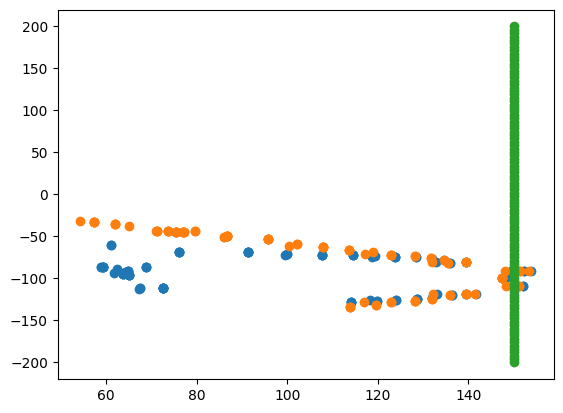

In [7]:


plt.scatter(cx_cent_new,cy_cent_new)
plt.scatter(cx_cent,cy_cent)

plt.scatter(df_walk.X,df_walk.Y)

In [8]:
centroid

[np.float64(114.12222715967584),
 np.float64(-128.09631870648056),
 np.float64(37.533343204617424)]